In [3]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [5]:
Directorio = 'data/lunar/training/catalogs/'
DirectorioF = Directorio + 'apollo12_catalog_GradeA_final.csv'
DataTraining = pd.read_csv(DirectorioF)
DataTraining



,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


In [34]:
#Haremos toda la solución con el dato de la segunda fila, al final lo generalizamos
row = DataTraining.iloc[14]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time_rel = row['time_rel(sec)']
test_filename = row.filename

#Aquí leemos el directorio individual
DirectorioI = 'data/lunar/training/data/S12_GradeA/'
DirectorioIF = f'{DirectorioI}{test_filename}.csv'
DataTrainingI = pd.read_csv(DirectorioIF)


In [35]:
#leer mseed
mseed_file = f'{DirectorioI}{test_filename}.mseed'
st = read(mseed_file)
st[0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1970-12-31T00:00:00.339000Z
         endtime: 1971-01-01T00:00:01.848434Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572411
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

In [36]:
# This is how you get the data and the time, which is in seconds
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# Start time of trace (another way to get the relative arrival time using datetime)
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()
tr


XA.S12.00.MHZ | 1970-12-31T00:00:00.339000Z - 1971-01-01T00:00:01.848434Z | 6.6 Hz, 572411 samples

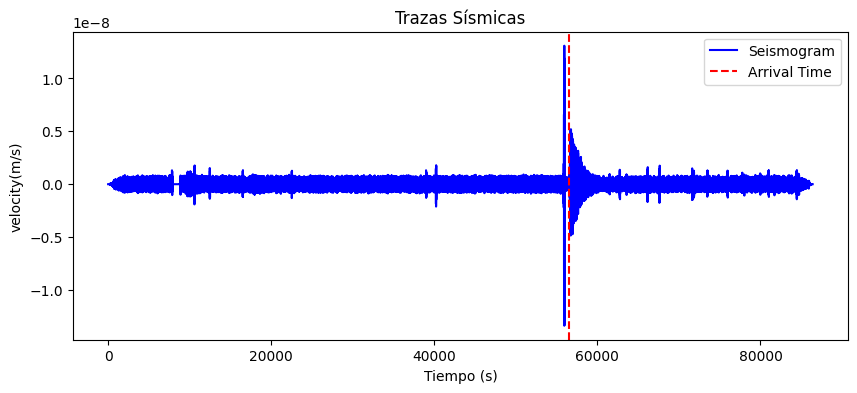

In [37]:
import matplotlib.pyplot as plt

# Graficar la traza (señal sísmica)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# Graficar los tiempos de la señal (tr_times) vs los datos de la señal (tr_data)
ax.plot(tr_times, tr_data, color='blue', label='Seismogram')

# Marcar el tiempo de llegada (arrival) en la traza con una línea roja
ax.axvline(x=arrival, color='red', linestyle='--', label='Arrival Time')

# Etiquetas y título del gráfico
ax.set_xlabel('Tiempo (s)')
ax.set_ylabel('velocity(m/s)')
ax.set_title('Trazas Sísmicas')
ax.legend()

# Mostrar la gráfica
plt.show()


In [38]:
# Definir la frecuencia de corte para el filtro high-pass
cutoff_freq = 3  # Ajusta este valor según sea necesario

# Crear una copia del objeto Stream
st_filt_hp = st.copy()

# Aplicar un filtro high-pass
st_filt_hp.filter('highpass', freq=cutoff_freq)


# Set the minimum frequency
minfreq = 0.5
maxfreq = 1

# Going to create a separate trace for the filter data
st_filt = st_filt_hp.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

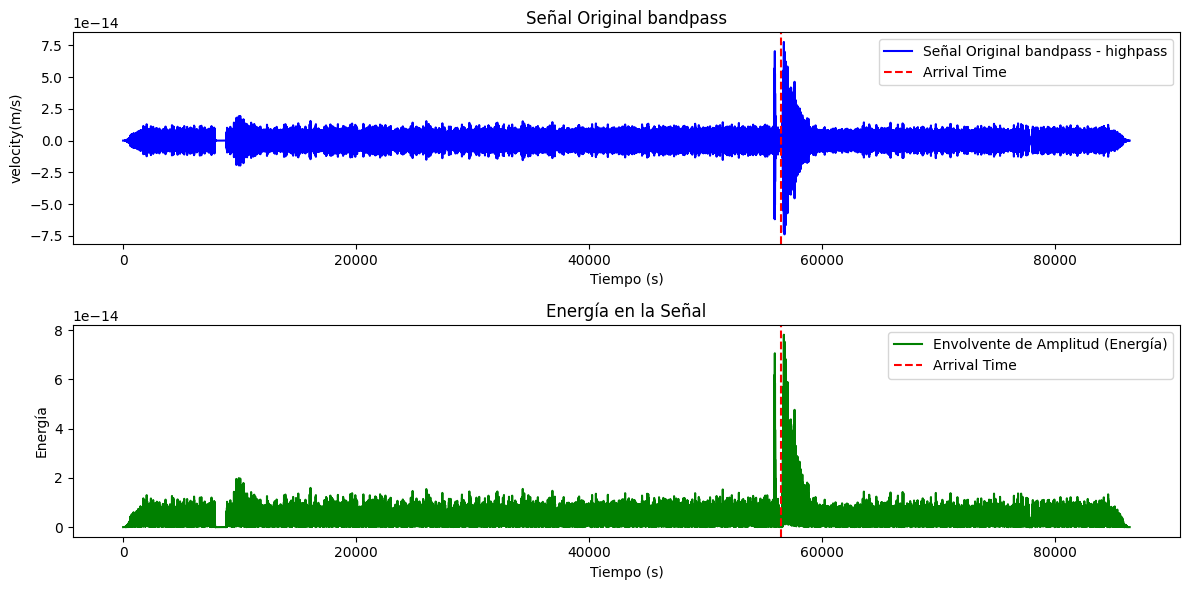

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# Calcular el envolvente de la señal usando la transformada de Hilbert
analytical_signal = hilbert(tr_data_filt)
amplitude_envelope = np.abs(analytical_signal)

# Graficar la señal original y su envolvente
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# Graficar la traza original
ax[0].plot(tr_times, tr_data_filt, color='blue', label='Señal Original bandpass - highpass')
ax[0].set_xlabel('Tiempo (s)')
ax[0].set_ylabel('velocity(m/s)')
ax[0].set_title('Señal Original bandpass')
ax[0].axvline(x=arrival, color='red', linestyle='--', label='Arrival Time')
ax[0].legend()

# Graficar la envolvente de la señal (energía)
ax[1].plot(tr_times, amplitude_envelope, color='green', label='Envolvente de Amplitud (Energía)')
ax[1].set_xlabel('Tiempo (s)')
ax[1].set_ylabel('Energía')
ax[1].set_title('Energía en la Señal')
ax[1].axvline(x=arrival, color='red', linestyle='--', label='Arrival Time')
ax[1].legend()

plt.tight_layout()
plt.show()


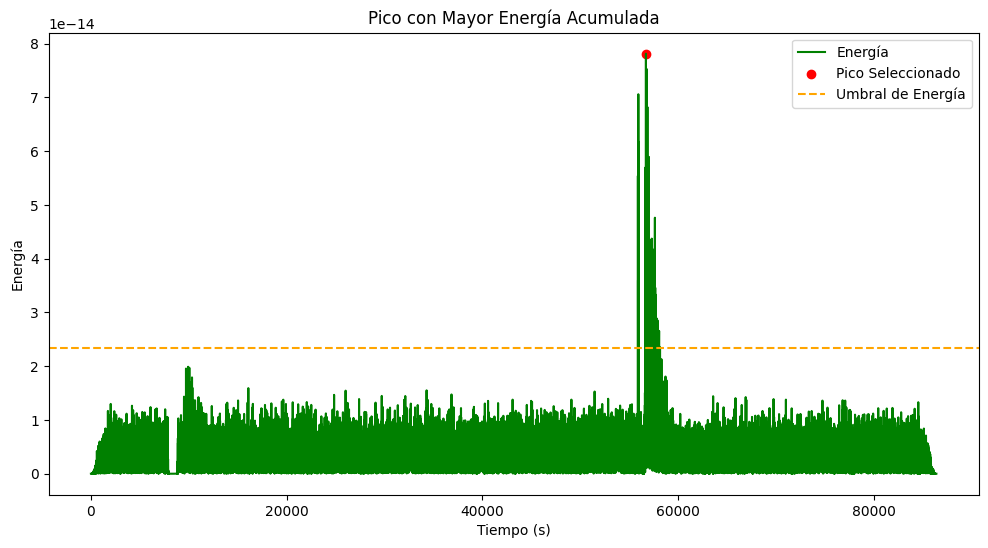

Pico seleccionado con mayor energía acumulada: 375758


In [40]:
import numpy as np
from scipy.signal import find_peaks

# Detectar picos en la energía
min_distance = 40000
threshold = np.percentile(amplitude_envelope, 99.5)  # Ajustar percentil si es necesario
peaks, properties = find_peaks(amplitude_envelope, height=threshold, distance=min_distance)

# Definir ventana para acumular energía alrededor de cada pico
window_size = 5000  # Puedes ajustar este tamaño según tus datos

# Calcular la energía acumulada en la vecindad de cada pico
accumulated_energy = []
for peak in peaks:
    left = max(0, peak - window_size)
    right = min(len(amplitude_envelope), peak + window_size)
    energy_sum = np.sum(amplitude_envelope[left:right])
    accumulated_energy.append(energy_sum)

# Seleccionar el pico con mayor energía acumulada
max_energy_peak_idx = np.argmax(accumulated_energy)
best_peak = peaks[max_energy_peak_idx]

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(tr_times, amplitude_envelope, color='green', label='Energía')
plt.scatter(tr_times[best_peak], amplitude_envelope[best_peak], color='red', label='Pico Seleccionado')
plt.axhline(y=threshold, color='orange', linestyle='--', label='Umbral de Energía')
plt.title('Pico con Mayor Energía Acumulada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Energía')
plt.legend()

plt.show()

print(f'Pico seleccionado con mayor energía acumulada: {best_peak}')


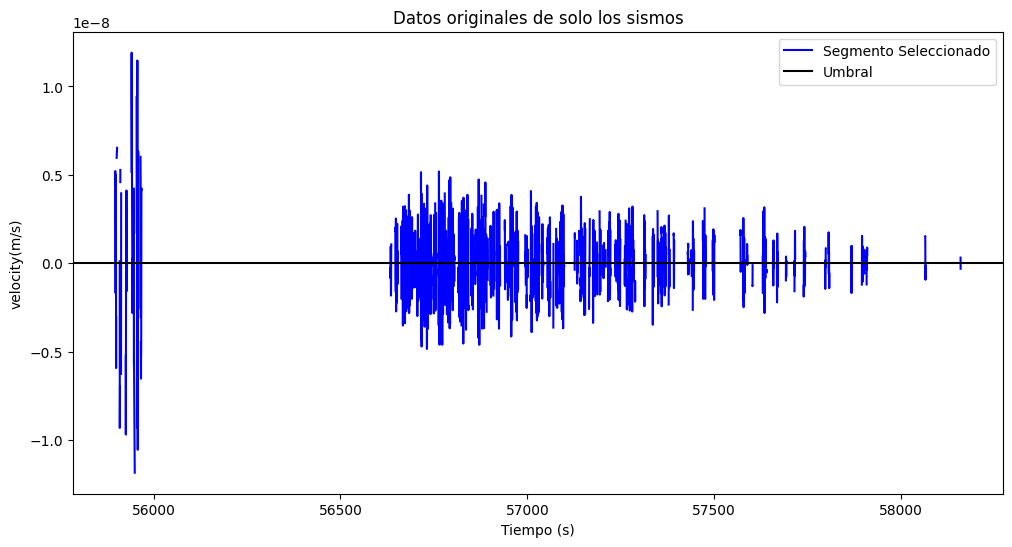

In [41]:

# Encontrar los índices donde la envolvente supera el umbral
above_threshold = amplitude_envelope > threshold
indices = np.where(above_threshold)[0]

for a in indices:
    data_util = tr[indices]

# Inicializar listas para almacenar los eventos detectados
start_indices = []
end_indices = []

# Buscar inicios y finales de los eventos
if len(indices) > 0:
    # Comenzar a rastrear el inicio del evento
    start_index = indices[0]
    
    for i in range(1, len(indices)):
        # Si el índice actual no es consecutivo al anterior, se ha encontrado un nuevo evento
        if indices[i] != indices[i-1] + 1:
            end_indices.append(indices[i-1])  # Añadir el final del evento anterior
            start_indices.append(start_index)  # Añadir el inicio del evento
            start_index = indices[i]  # Iniciar el nuevo evento

    # Añadir el último evento
    end_indices.append(indices[-1])
    start_indices.append(start_index)

# Graficar todos los eventos detectados en la misma figura
plt.figure(figsize=(12, 6))

for start, end in zip(start_indices, end_indices):
    selected_times = tr_times[start:end + 1]
    selected_data = tr_data[start:end + 1]
    data_util = tr[start:end + 1]

    # Graficar el segmento seleccionado
    plt.plot(selected_times, selected_data, color='blue', label='Segmento Seleccionado' if start == start_indices[0] else "")

# Graficar el umbral
plt.axhline(y=0, color='black', label='Umbral')
plt.xlabel('Tiempo (s)')
plt.ylabel('velocity(m/s)')
plt.title('Datos originales de solo los sismos')
plt.legend()
plt.show()


In [457]:

# Descargar el archivo si queremos ver todo el rango de los sismos


RangoSismo = DataTrainingI.iloc[above_threshold]
RangoSismo.to_csv('DataRangoSismo.csv', index=False)

# Mostrar el resultado
RangoSismo




,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
83317,1975-06-26T03:29:36.692943,12576.150943,1.088913e-09
83318,1975-06-26T03:29:36.843887,12576.301887,9.293712e-10
83319,1975-06-26T03:29:36.994830,12576.452830,-2.773785e-10
83320,1975-06-26T03:29:37.145774,12576.603774,-1.292998e-09
83321,1975-06-26T03:29:37.296717,12576.754717,-1.495641e-09
...,...,...,...
326926,1975-06-26T13:42:27.862755,49347.320755,-6.063950e-10
326927,1975-06-26T13:42:28.013698,49347.471698,-6.130735e-10
326928,1975-06-26T13:42:28.164642,49347.622642,-2.503173e-10
326929,1975-06-26T13:42:28.315585,49347.773585,1.658676e-10


In [45]:
#Descargar el archivo para ver cuándo ocurrió el pico del sismo
PicoSismo = DataTrainingI.iloc[[best_peak]]
# PicoSismo.to_csv('DataPicoSismo.csv', index=False)
# Mostrar el resultado
PicoSismo


,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
375758,1970-12-31T15:45:18.527679,56718.188679,-1.700496e-09
